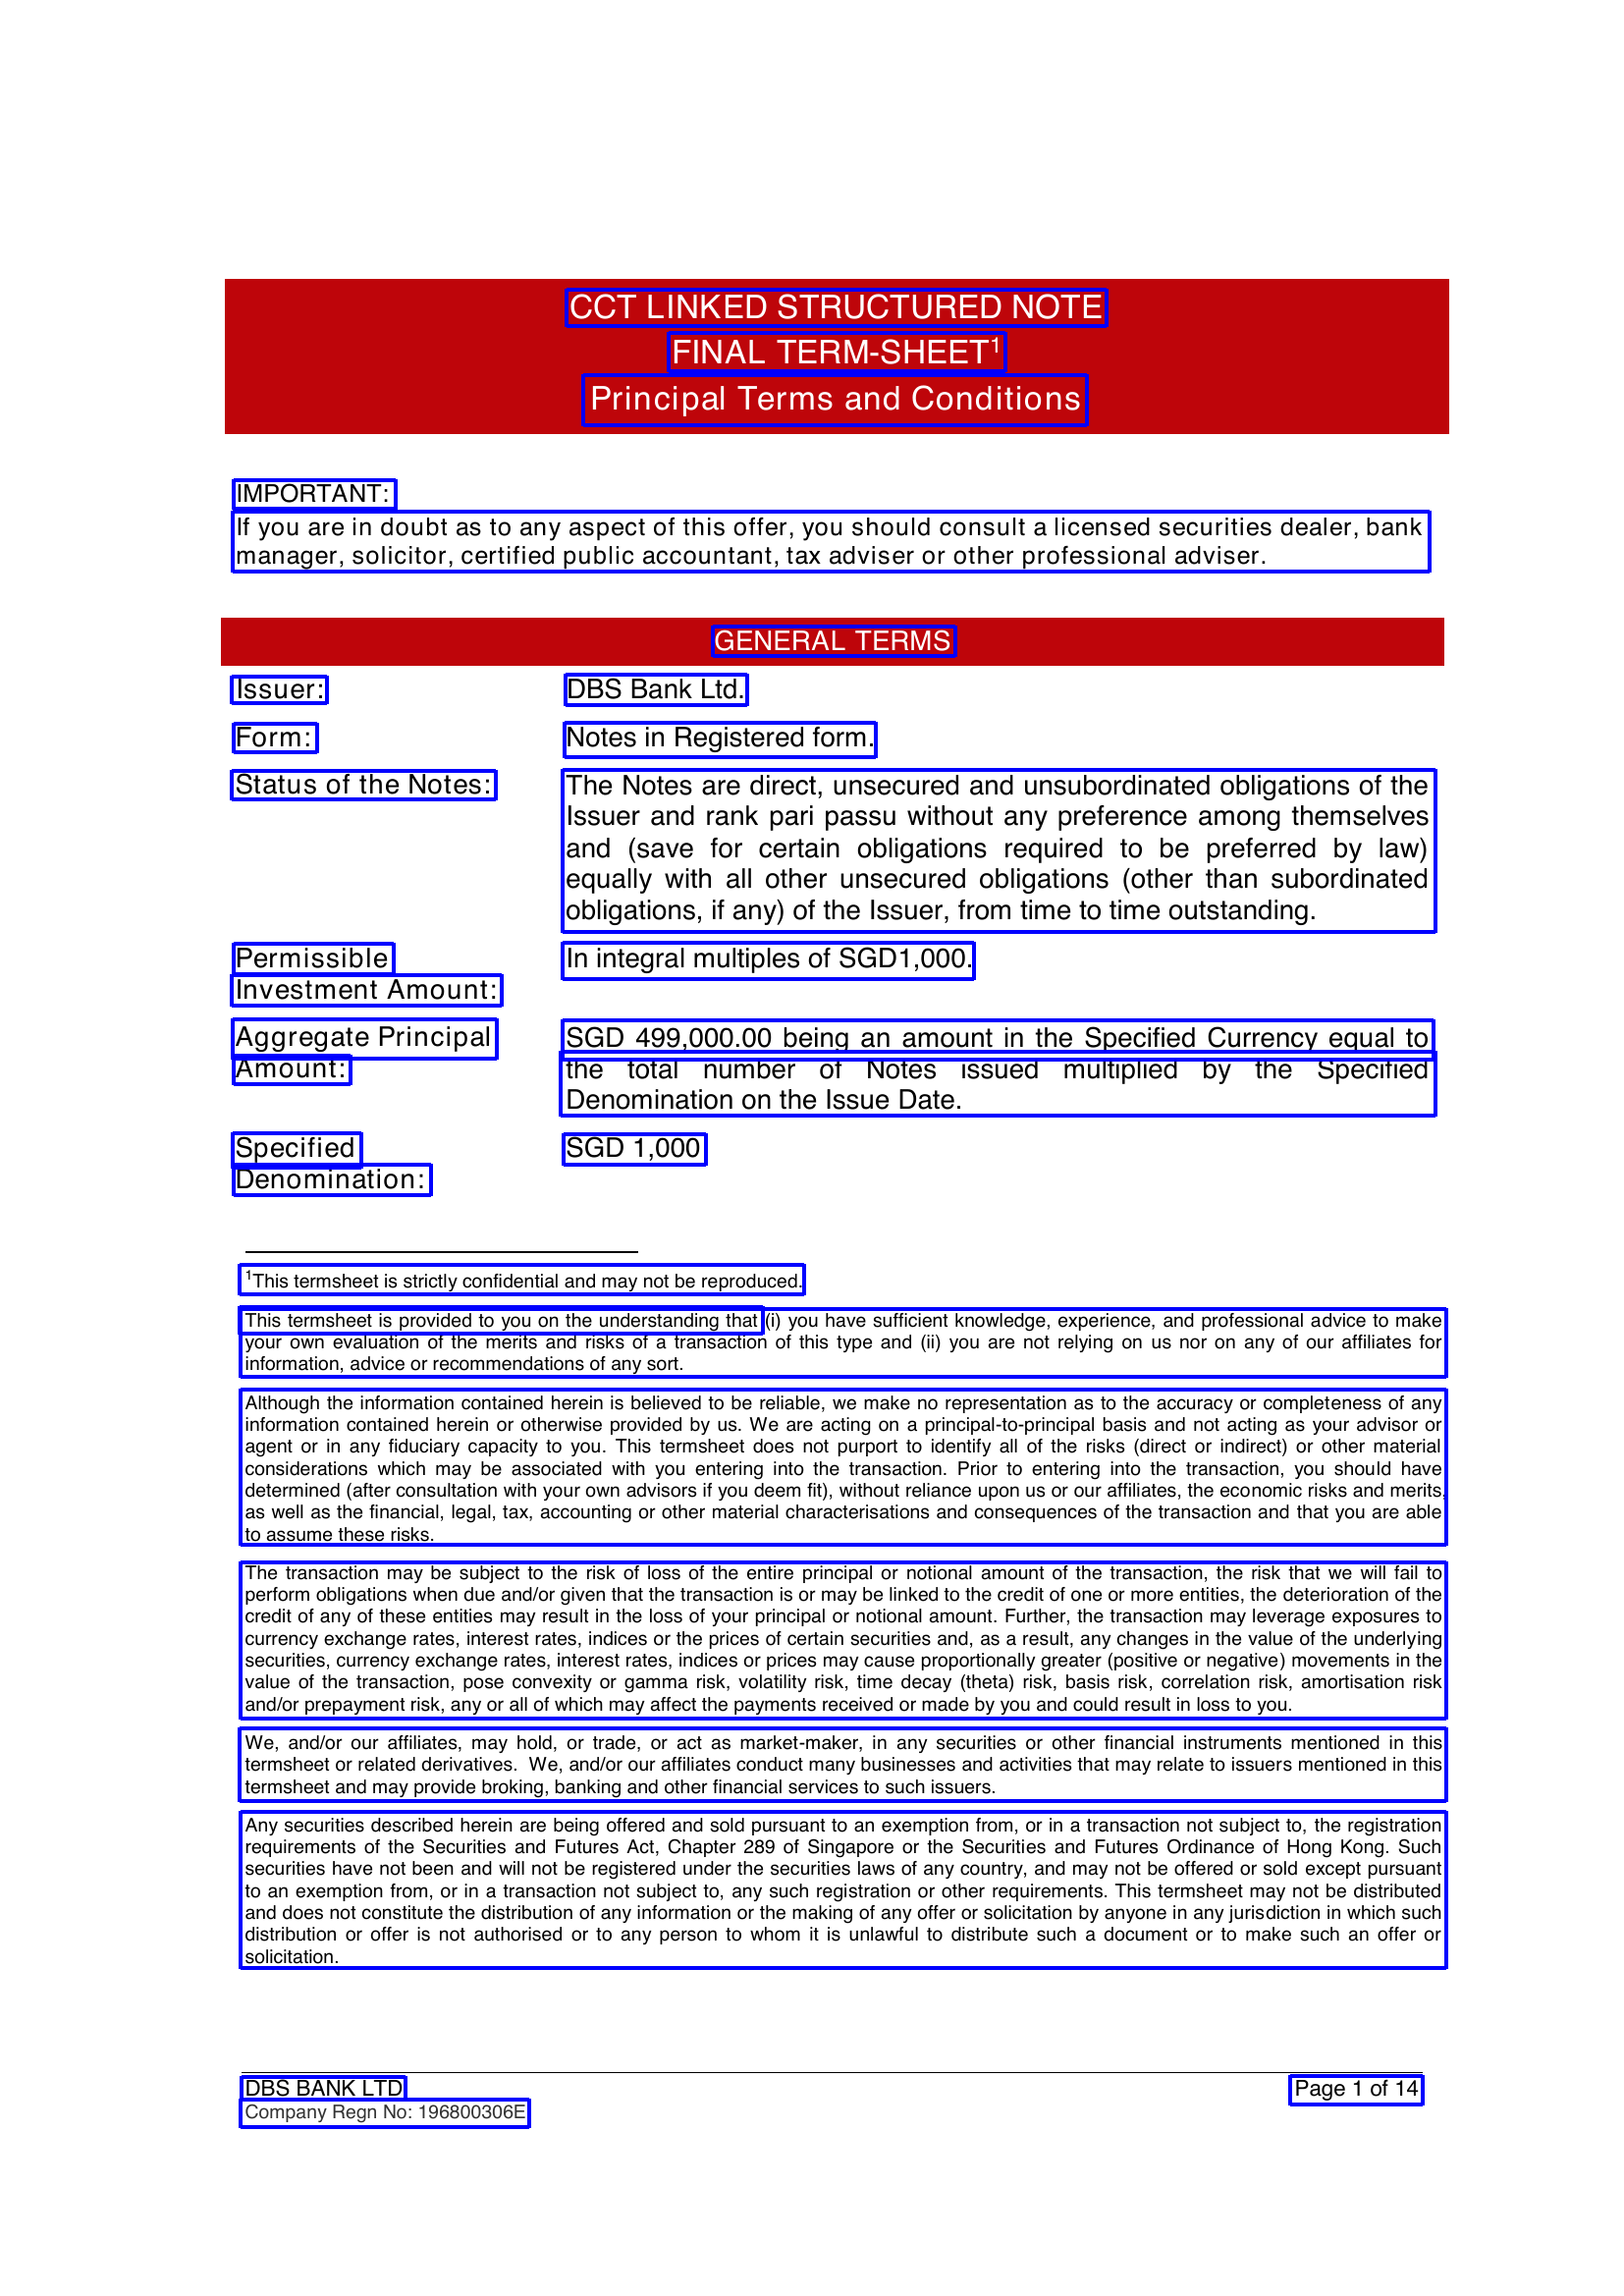

In [18]:
#基础+动态闸值+水平不重合文本不合并+nlp
import torch
from transformers import BertTokenizer, BertForNextSentencePrediction, BertModel
from sklearn.metrics.pairwise import cosine_similarity
from pdf2image import convert_from_path
import easyocr
import numpy as np
from PIL import Image, ImageDraw
from IPython.display import display

# 初始化BERT模型和分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
nsp_model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# 初始化OCR阅读器
reader = easyocr.Reader(['en'])

# 将PDF转换为图像
pdf_path = '/Users/zhoushengfang/Desktop/毕业论文/cct-linked-structured-note.pdf'
images = convert_from_path(pdf_path)

# 在第一页图像上执行OCR
bounds = reader.readtext(np.array(images[0]), min_size=10, slope_ths=0.5, ycenter_ths=0.7, height_ths=1.2, width_ths=0.85, decoder='beamsearch', beamWidth=10)

# 获取句子表示
def get_sentence_embedding(sentence, max_length=512):
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, max_length=max_length)
    outputs = bert_model(**inputs)
    cls_embedding = outputs.last_hidden_state[0, 0, :].detach().numpy()
    return cls_embedding

# NSP预测
def nsp_predict(sentence_a, sentence_b, max_length=512):
    inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt', truncation=True, max_length=max_length)
    outputs = nsp_model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return probs[0][0].item()  # 返回是连续的概率

# 计算动态阈值
def calculate_dynamic_thresholds(bounds):
    vertical_distances = []
    horizontal_overlaps = []
    for i in range(1, len(bounds)):
        prev_bound = bounds[i-1]
        curr_bound = bounds[i]
        vertical_distance = curr_bound[0][0][1] - prev_bound[0][3][1]
        horizontal_overlap = max(0, (min(curr_bound[0][1][0], prev_bound[0][1][0]) - max(curr_bound[0][0][0], prev_bound[0][0][0])) / \
                             min(curr_bound[0][1][0] - curr_bound[0][0][0], prev_bound[0][1][0] - prev_bound[0][0][0]))
        vertical_distances.append(vertical_distance)
        horizontal_overlaps.append(horizontal_overlap)
    
    vertical_threshold = np.percentile(vertical_distances, 70)  # 动态计算70百分位垂直距离作为阈值
    horizontal_threshold = np.percentile(horizontal_overlaps, 10)  # 动态计算10百分位水平重叠作为阈值
    return vertical_threshold, horizontal_threshold

# 获取动态阈值
vertical_threshold, horizontal_threshold = calculate_dynamic_thresholds(bounds)

# 初步合并文本块
def initial_merge(bounds, vertical_threshold, horizontal_threshold, paragraph_threshold=1.5):
    merged_bounds = []  # 存放初步合并后的文本框
    for bound in bounds:
        if len(merged_bounds) == 0:
            merged_bounds.append(bound)
        else:
            last_bound = merged_bounds[-1]
            vertical_distance = bound[0][0][1] - last_bound[0][3][1]
            horizontal_overlap = max(0, (min(bound[0][1][0], last_bound[0][1][0]) - max(bound[0][0][0], last_bound[0][0][0])) / \
                                 min(bound[0][1][0] - bound[0][0][0], last_bound[0][1][0] - last_bound[0][0][0]))

            if vertical_distance < vertical_threshold * paragraph_threshold and horizontal_overlap > horizontal_threshold:
                new_bound = [
                    [min(bound[0][0][0], last_bound[0][0][0]), min(bound[0][0][1], last_bound[0][0][1])],  # 左上角
                    [max(bound[0][1][0], last_bound[0][1][0]), min(bound[0][1][1], last_bound[0][1][1])],  # 右上角
                    [max(bound[0][2][0], last_bound[0][2][0]), max(bound[0][2][1], last_bound[0][2][1])],  # 右下角
                    [min(bound[0][3][0], last_bound[0][3][0]), max(bound[0][3][1], last_bound[0][3][1])]   # 左下角
                ]
                new_text = last_bound[1] + ' ' + bound[1]
                merged_bounds[-1] = (new_bound, new_text, bound[2])
            else:
                merged_bounds.append(bound)
    return merged_bounds

# 基于BERT模型进一步合并文本块
def refine_merge(merged_bounds, nsp_threshold=0.7, similarity_threshold=0.8):
  refined_bounds = []  # 存放进一步合并后的文本框
  for current_bound in merged_bounds:
    closest_next_bound = None
    closest_vertical_distance = float('inf')
    for next_bound in merged_bounds[merged_bounds.index(current_bound) + 1:]:
      # Check for horizontal overlap
      if current_bound[0][0][0] <= next_bound[0][1][0] and next_bound[0][0][0] <= current_bound[0][1][0]:
        vertical_distance = next_bound[0][0][1] - current_bound[0][3][1]
        if vertical_distance >= 0 and vertical_distance < closest_vertical_distance:
          closest_next_bound = next_bound
          closest_vertical_distance = vertical_distance

    if closest_next_bound and should_merge(current_bound[1], closest_next_bound[1], nsp_threshold, similarity_threshold):
      new_bound = [
          [min(current_bound[0][0][0], closest_next_bound[0][0][0]), min(current_bound[0][0][1], closest_next_bound[0][0][1])],
          [max(current_bound[0][1][0], closest_next_bound[0][1][0]), min(current_bound[0][1][1], closest_next_bound[0][1][1])],
          [max(current_bound[0][2][0], closest_next_bound[0][2][0]), max(current_bound[0][2][1], closest_next_bound[0][2][1])],
          [min(current_bound[0][3][0], closest_next_bound[0][3][0]), max(current_bound[0][3][1], closest_next_bound[0][3][1])]
      ]
      new_text = current_bound[1] + ' ' + closest_next_bound[1]
      refined_bounds.append((new_bound, new_text, closest_next_bound[2]))
    else:
      refined_bounds.append(current_bound)
  return refined_bounds

# 判断是否合并
def should_merge(sentence_a, sentence_b, nsp_threshold=0.7, similarity_threshold=0.8):
    nsp_prob = nsp_predict(sentence_a, sentence_b)
    embedding_a = get_sentence_embedding(sentence_a)
    embedding_b = get_sentence_embedding(sentence_b)
    similarity = cosine_similarity([embedding_a], [embedding_b])[0][0]
    
    return nsp_prob > nsp_threshold or similarity > similarity_threshold

# 初步合并
merged_bounds = initial_merge(bounds, vertical_threshold, horizontal_threshold)

# 进一步合并
refined_bounds = refine_merge(merged_bounds)

# 定义绘制边界框的函数
def draw_boxes(image, bounds, color='blue', width=4):
    draw = ImageDraw.Draw(image)
    for bound in bounds:
        p0, p1, p2, p3 = bound[0]
        draw.line([*p0, *p1, *p2, *p3, *p0], fill=color, width=width)
    return image

# 在图像上绘制边界框
draw_boxes(images[0], merged_bounds)